<center><b><h1>Formative Assessment (Stock Price Prediction)</h1></b></center>
<center><h3>Machine Learning</h3></center>



## Importing required libraries

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd 
import json
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

## Setup Kaggle API

In [2]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
kaggle_username = "oluwarotimiadesina"
kaggle_key = "c6242324dc4a957939185473c0631e48"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

## Download and explore dataset

In [4]:
# Download the dataset, it will be in a .zip file.
!kaggle datasets download -d borismarjanovic/price-volume-data-for-all-us-stocks-etfs

price-volume-data-for-all-us-stocks-etfs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Unzip the downloaded file
!unzip -o price-volume-data-for-all-us-stocks-etfs.zip

Streaming output truncated to the last 5000 lines.
  inflating: Stocks/ergf.us.txt      
  inflating: Stocks/erh.us.txt       
  inflating: Stocks/eri.us.txt       
  inflating: Stocks/eric.us.txt      
  inflating: Stocks/erie.us.txt      
  inflating: Stocks/erii.us.txt      
  inflating: Stocks/erj.us.txt       
  inflating: Stocks/erm.us.txt       
  inflating: Stocks/ern.us.txt       
  inflating: Stocks/eros.us.txt      
  inflating: Stocks/eryp.us.txt      
  inflating: Stocks/es.us.txt        
  inflating: Stocks/esba.us.txt      
  inflating: Stocks/esbk.us.txt      
  inflating: Stocks/esca.us.txt      
  inflating: Stocks/esdi.us.txt      
  inflating: Stocks/esdiw.us.txt     
  inflating: Stocks/ese.us.txt       
  inflating: Stocks/esea.us.txt      
  inflating: Stocks/eses.us.txt      
  inflating: Stocks/esg.us.txt       
  inflating: Stocks/esgd.us.txt      
  inflating: Stocks/esge.us.txt      
  inflating: Stocks/esgf.us.txt      
  inflating: Stocks/esgg.us.txt      

## Define Model Class

In [6]:
class LstmModel:

    def __init__(self, file_path, num_epochs, time_step):
        self.file_path = file_path
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.num_epochs = num_epochs
        self.time_step = time_step

    def run_model(self):
        close_dataframe = self.read_data()

        close_dataframe = self.scale_data(close_dataframe)

        train_data, test_data = self.split_data(close_dataframe)

        X_train, y_train = self.create_dataset(train_data, self.time_step)
        X_test, ytest = self.create_dataset(test_data, self.time_step)

        lstm_model = self.initialize_model(input_shape=(self.time_step, 1))

        lstm_model = self.train_model(X_train, y_train, X_test, ytest, self.num_epochs, lstm_model)

        predictions = self.make_prediction(lstm_model, X_test)
        accuracy = self.get_accuracy(ytest, predictions)

        train_predictions = self.make_prediction(lstm_model, X_train)
        test_predictions = self.make_prediction(lstm_model, X_test)
        self.plot_prediction_graph(close_dataframe, self.time_step, train_predictions, test_predictions)

    def read_data(self):
        dataframe = pd.read_csv(self.file_path)
        print("Starting Date of time series data: \n")
        print(dataframe.head())
        print("\n")
        print("Ending Date of time series data: \n")
        print(dataframe.tail())
        print("\n")

        print("Extracting stock price closing value...\n")
        close_dataframe = dataframe.reset_index()["Close"]
        print(close_dataframe)
        print("\n")

        print("Ploting stock closing price: \n")
        plt.rcParams["figure.figsize"] = (8.0,6.0)
        plt.plot(close_dataframe, color='red', linewidth=1, markersize=2)
        plt.show()

        return close_dataframe

    def scale_data(self, close_dataframe):
        print("Scaling data to fit within a range of 0 - 1... \n")
        close_dataframe = self.scaler.fit_transform(
            np.array(close_dataframe).reshape(-1, 1))
        print(close_dataframe)
        print("\n")
        return close_dataframe

    def split_data (self, close_dataframe):
        training_size = int(len(close_dataframe) * 0.6)
        test_size = len(close_dataframe) - training_size
        print("Splitting the data.\nTraining Size: {}.\nTesting Size: {}\n".format(
            training_size, test_size
        ))
        return (close_dataframe[0:training_size,:], 
                close_dataframe[training_size:len(close_dataframe),:1])
        
    def create_dataset(self, current_dataset, time_step):
        print("Transforming data to have {} dependent variables and one target...".format(
            time_step
        ))
        feature_data, target_data = [], []
        for index in range(0, len(current_dataset)-time_step-1):
            feature_data.append(current_dataset[index: index+time_step, 0])
            target_data.append(current_dataset[index+time_step, 0])
        
        feature_data = np.array(feature_data)
        target_data = np.array(target_data)

        print("Feature Data shape: ", feature_data.shape)
        print("Target Data shape: ", target_data.shape)
        print("\n")
        return feature_data, target_data

    def initialize_model(self, input_shape, optimizer='adam'):
        print("Initializing LSTM model... \n")
        lstm_model=Sequential()
        lstm_model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
        lstm_model.add(LSTM(50,return_sequences=True))
        lstm_model.add(LSTM(50))
        lstm_model.add(Dense(1))
        lstm_model.compile(loss='mean_squared_error',optimizer='adam')
        print(lstm_model.summary())
        print("\n")

        return lstm_model

    def train_model(self, x_train, y_train, x_test, y_test, n_epochs, lstm_model):
        print("About to fit model to dataset... \n")
        lstm_model.fit(x_train,
                       y_train,
                       validation_data=(x_test,y_test),
                       epochs=n_epochs,
                       batch_size=64,
                       verbose=1)
        print("Model fitting is complete. \n")
        return lstm_model

    def make_prediction(self, lstm_model, feature_dataset):
        print("About to make prediction...\n")
        prediction = lstm_model.predict(feature_dataset)
        prediction = self.scaler.inverse_transform(prediction)
        print("Predictions: \n", prediction)
        print("\n")
        return prediction

    def get_accuracy(self, y_train, y_predict):
        print("Computing prediction accuracy...\n")
        rmse_accuracy = math.sqrt(mean_squared_error(y_train, y_predict))
        print("Root mean squared error: {}".format(rmse_accuracy))
        return rmse_accuracy

    def plot_prediction_graph(self, original_dataframe, time_step, train_predict, test_predict):
        train_predict_plot = np.empty_like(original_dataframe)
        train_predict_plot[:,:] = np.nan
        train_predict_plot[time_step : len(train_predict) + time_step, :] = train_predict

        test_predict_plot = np.empty_like(original_dataframe)
        test_predict_plot[:,:] = np.nan
        test_predict_plot[time_step + len(train_predict) + time_step + 1 : len(original_dataframe)-1, :] = test_predict


        plt.rcParams["figure.figsize"] = (20,15)
        plt.plot(self.scaler.inverse_transform(original_dataframe))
        plt.plot(train_predict_plot)
        plt.plot(test_predict_plot)
        plt.xlabel('Time')
        plt.ylabel('Stock Closing Price')
        plt.title("Closing Price prediction vs actual price")
        plt.show()







## Predict the closing price against the date of JNJ company and show the results as a graph.

Starting Date of time series data: 

         Date    Open    High     Low   Close   Volume  OpenInt
0  1970-01-02  0.6104  0.6104  0.5941  0.5941  1468563        0
1  1970-01-05  0.5941  0.5941  0.5776  0.5776  1185461        0
2  1970-01-06  0.5776  0.5864  0.5776  0.5864  1273931        0
3  1970-01-07  0.5864  0.5941  0.5864  0.5864   406950        0
4  1970-01-08  0.5864  0.5941  0.5864  0.5941   566189        0


Ending Date of time series data: 

             Date    Open    High     Low   Close   Volume  OpenInt
12069  2017-11-06  140.01  140.49  139.72  139.76  4220661        0
12070  2017-11-07  140.08  140.15  138.91  139.77  4194070        0
12071  2017-11-08  139.70  141.87  139.46  141.32  4440694        0
12072  2017-11-09  140.86  141.41  139.80  140.35  3516887        0
12073  2017-11-10  140.13  140.13  138.61  139.56  4240286        0


Extracting stock price closing value...

0          0.5941
1          0.5776
2          0.5864
3          0.5864
4          0.5941
 

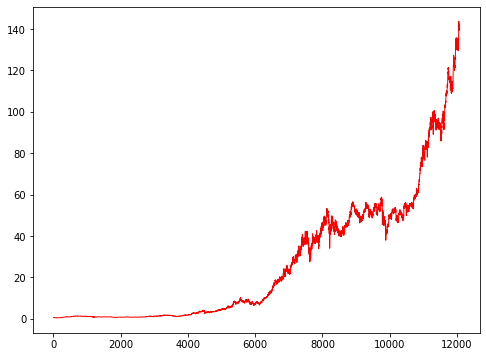

Scaling data to fit within a range of 0 - 1... 

[[0.0014772 ]
 [0.001362  ]
 [0.00142344]
 ...
 [0.98394275]
 [0.97717078]
 [0.97165547]]


Splitting the data.
Training Size: 7244.
Testing Size: 4830

Transforming data to have 100 dependent variables and one target...
Feature Data shape:  (7143, 100)
Target Data shape:  (7143,)


Transforming data to have 100 dependent variables and one target...
Feature Data shape:  (4729, 100)
Target Data shape:  (4729,)


Initializing LSTM model... 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                         

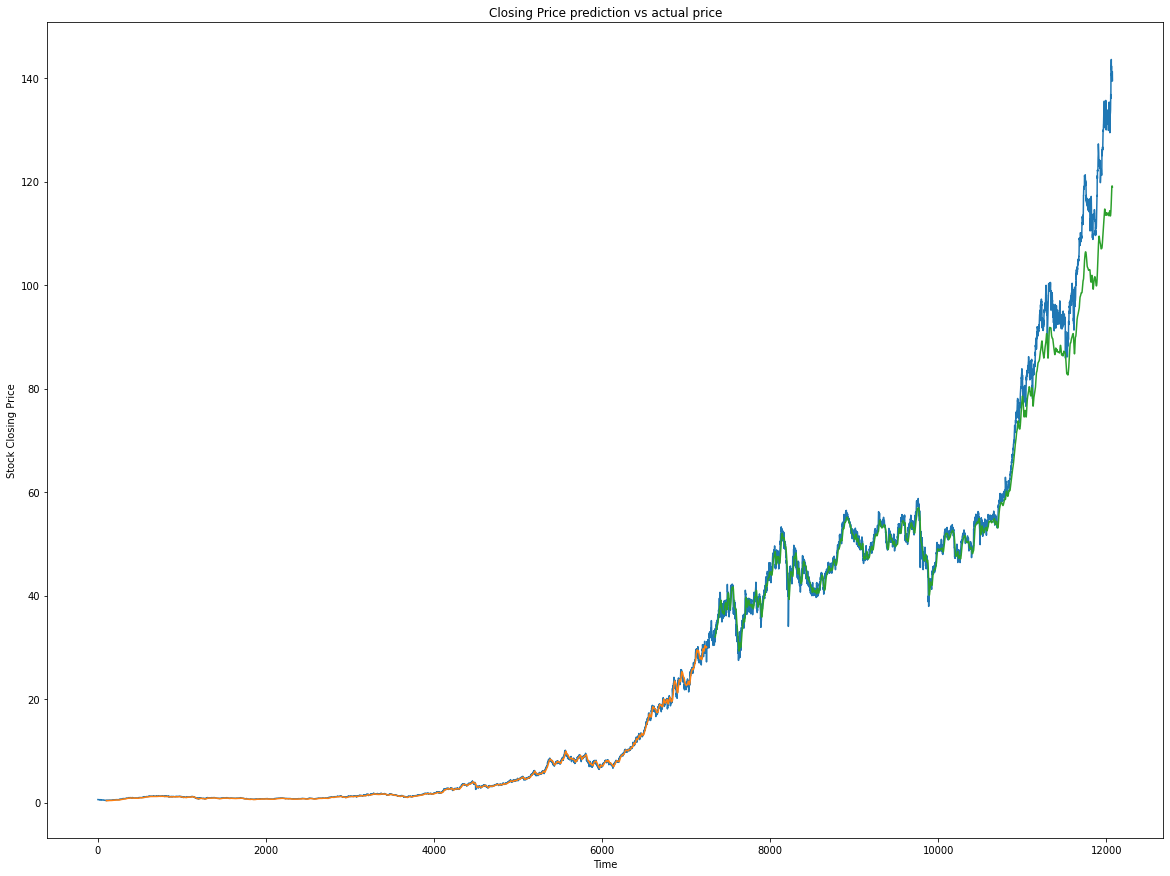

In [7]:
jnj_company_model = LstmModel(file_path = "Stocks/jnj.us.txt",  num_epochs=10, time_step=100)
jnj_company_model.run_model()

## Predict the closing price against the date of JP Morgan and show the results as a graph.

Starting Date of time series data: 

         Date    Open    High     Low   Close  Volume  OpenInt
0  1970-01-02  3.1254  3.1254  3.0920  3.1254   29448        0
1  1970-01-05  3.1254  3.1339  3.1004  3.1254   38447        0
2  1970-01-06  3.1254  3.1588  3.1087  3.1588   33540        0
3  1970-01-07  3.1671  3.2503  3.1671  3.2337   88350        0
4  1970-01-08  3.2254  3.2254  3.1838  3.2254   26177        0


Ending Date of time series data: 

             Date    Open     High     Low   Close    Volume  OpenInt
12069  2017-11-06  101.34  101.687  100.66  100.78   8115897        0
12070  2017-11-07  100.56  100.750   98.25   98.75  18808493        0
12071  2017-11-08   98.27   98.370   97.15   97.64  18517768        0
12072  2017-11-09   97.12   98.215   96.81   97.63  13692746        0
12073  2017-11-10   97.81   98.340   97.50   97.51   9312355        0


Extracting stock price closing value...

0          3.1254
1          3.1254
2          3.1588
3          3.2337
4          3.

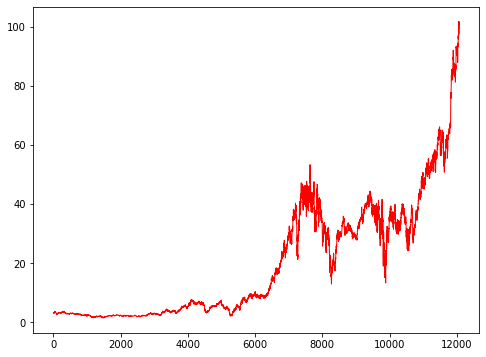

Scaling data to fit within a range of 0 - 1... 

[[0.01743122]
 [0.01743122]
 [0.0177639 ]
 ...
 [0.95886233]
 [0.95876272]
 [0.95756744]]


Splitting the data.
Training Size: 7244.
Testing Size: 4830

Transforming data to have 100 dependent variables and one target...
Feature Data shape:  (7143, 100)
Target Data shape:  (7143,)


Transforming data to have 100 dependent variables and one target...
Feature Data shape:  (4729, 100)
Target Data shape:  (4729,)


Initializing LSTM model... 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                       

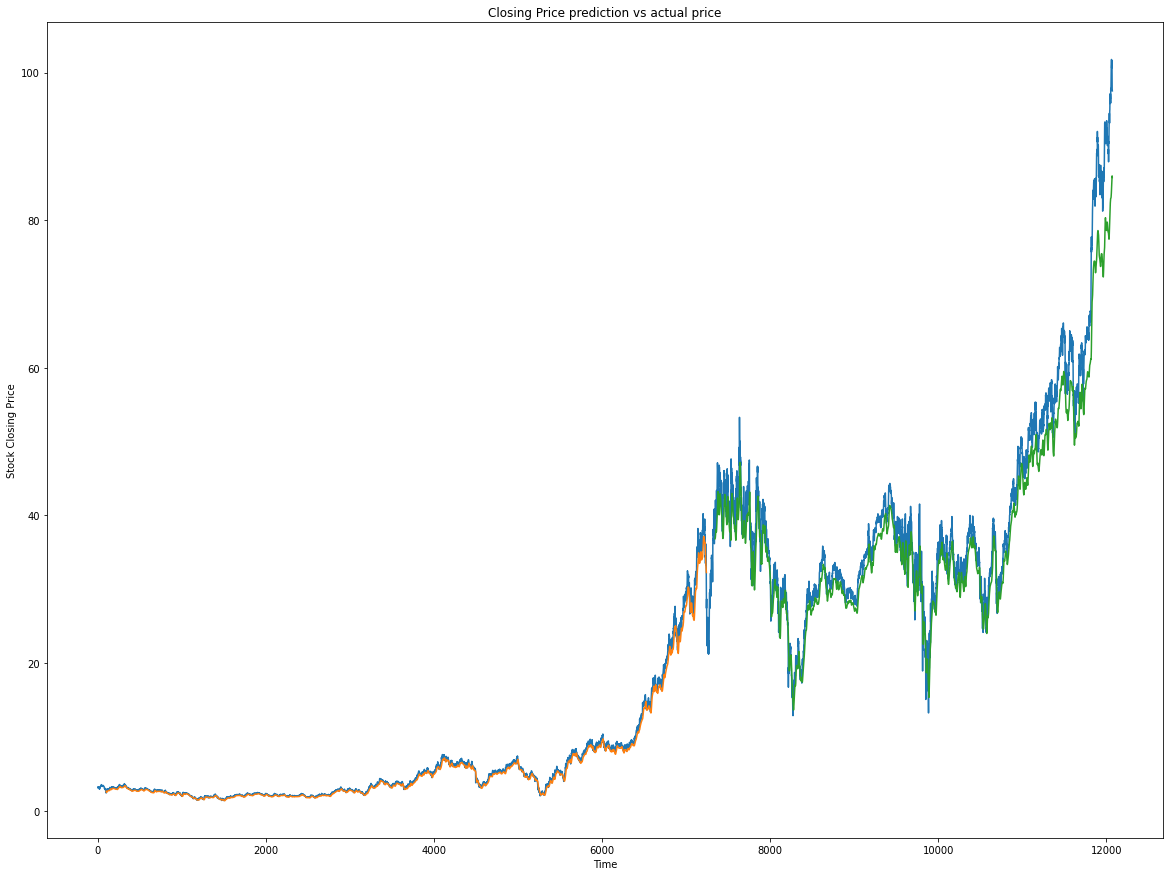

In [8]:
jpm_company_model = LstmModel(file_path = "Stocks/jpm.us.txt", num_epochs=10, time_step=100)
jpm_company_model.run_model()

## Predict the closing price against the date of Goldman Sachs and show the results as a graph.

Starting Date of time series data: 

         Date    Open    High     Low   Close    Volume  OpenInt
0  1999-05-04  67.665  68.780  62.329  62.659  24472946        0
1  1999-05-05  62.213  62.213  58.991  61.547   8295140        0
2  1999-05-06  60.542  61.773  59.712  60.488   3185852        0
3  1999-05-07  60.488  66.671  59.429  65.998   5331091        0
4  1999-05-10  65.331  65.441  62.549  62.941   2839054        0


Ending Date of time series data: 

            Date    Open     High     Low   Close   Volume  OpenInt
4656  2017-11-06  243.50  244.579  241.67  243.49  1733854        0
4657  2017-11-07  243.91  244.980  238.84  239.81  2435057        0
4658  2017-11-08  239.20  242.320  237.55  241.25  2349422        0
4659  2017-11-09  239.51  242.367  237.84  240.79  2122535        0
4660  2017-11-10  241.69  243.320  240.00  240.15  1844519        0


Extracting stock price closing value...

0        62.659
1        61.547
2        60.488
3        65.998
4        62.941
     

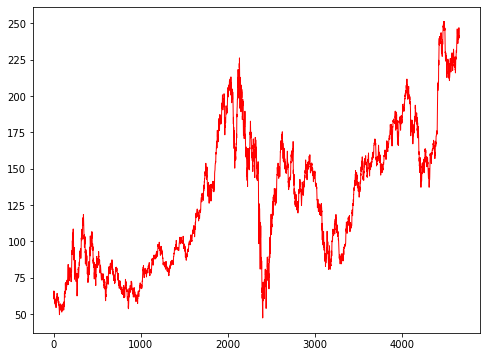

Scaling data to fit within a range of 0 - 1... 

[[0.0747481 ]
 [0.06929046]
 [0.06409294]
 ...
 [0.95126404]
 [0.94900639]
 [0.9458653 ]]


Splitting the data.
Training Size: 2796.
Testing Size: 1865

Transforming data to have 100 dependent variables and one target...
Feature Data shape:  (2695, 100)
Target Data shape:  (2695,)


Transforming data to have 100 dependent variables and one target...
Feature Data shape:  (1764, 100)
Target Data shape:  (1764,)


Initializing LSTM model... 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                       

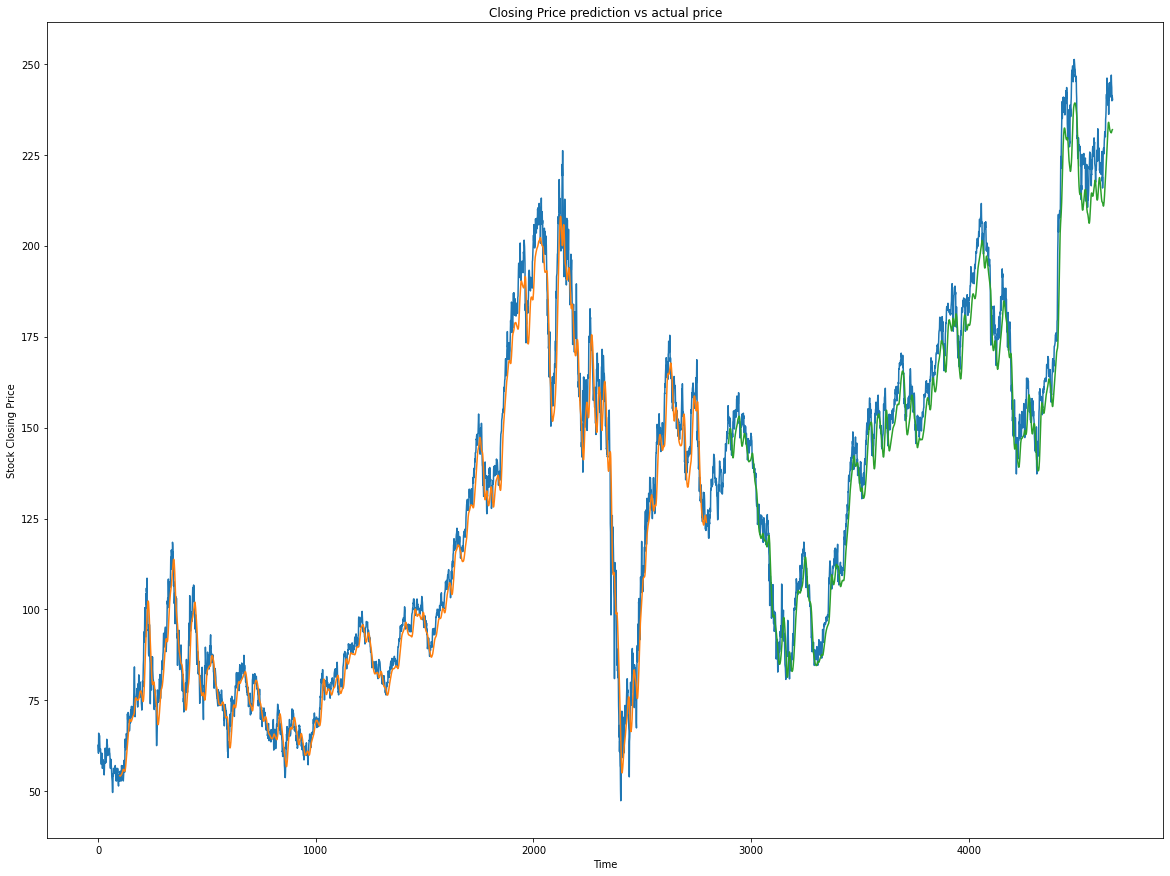

In [9]:
gs_company_model = LstmModel(file_path = "Stocks/gs.us.txt", num_epochs=10, time_step=100)
gs_company_model.run_model()

## Predict the closing price against the date of Nike and show the results as a graph.

Starting Date of time series data: 

         Date     Open     High      Low    Close    Volume  OpenInt
0  1987-08-19  0.24563  0.24793  0.23872  0.24337  13249179        0
1  1987-08-20  0.24337  0.24793  0.24337  0.24563  13869472        0
2  1987-08-21  0.24793  0.24793  0.24337  0.24563   2780866        0
3  1987-08-24  0.24337  0.24563  0.24337  0.24337  12754334        0
4  1987-08-25  0.24104  0.27093  0.24104  0.26389  31767365        0


Ending Date of time series data: 

            Date   Open    High    Low  Close    Volume  OpenInt
7615  2017-11-06  55.29  56.130  55.14  56.04   9241026        0
7616  2017-11-07  55.75  56.015  55.02  55.15   7364880        0
7617  2017-11-08  55.00  55.770  54.89  55.76   7078567        0
7618  2017-11-09  55.50  56.350  55.31  56.13  10946206        0
7619  2017-11-10  55.88  56.490  55.62  56.09   7535726        0


Extracting stock price closing value...

0        0.24337
1        0.24563
2        0.24563
3        0.24337
4        0.

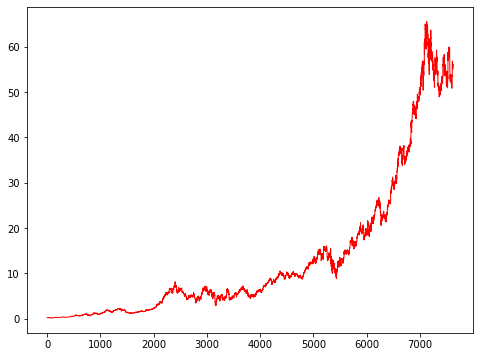

Scaling data to fit within a range of 0 - 1... 

[[0.00098379]
 [0.00101836]
 [0.00101836]
 ...
 [0.85012225]
 [0.85578147]
 [0.85516967]]


Splitting the data.
Training Size: 4572.
Testing Size: 3048

Transforming data to have 100 dependent variables and one target...
Feature Data shape:  (4471, 100)
Target Data shape:  (4471,)


Transforming data to have 100 dependent variables and one target...
Feature Data shape:  (2947, 100)
Target Data shape:  (2947,)


Initializing LSTM model... 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_16 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                       

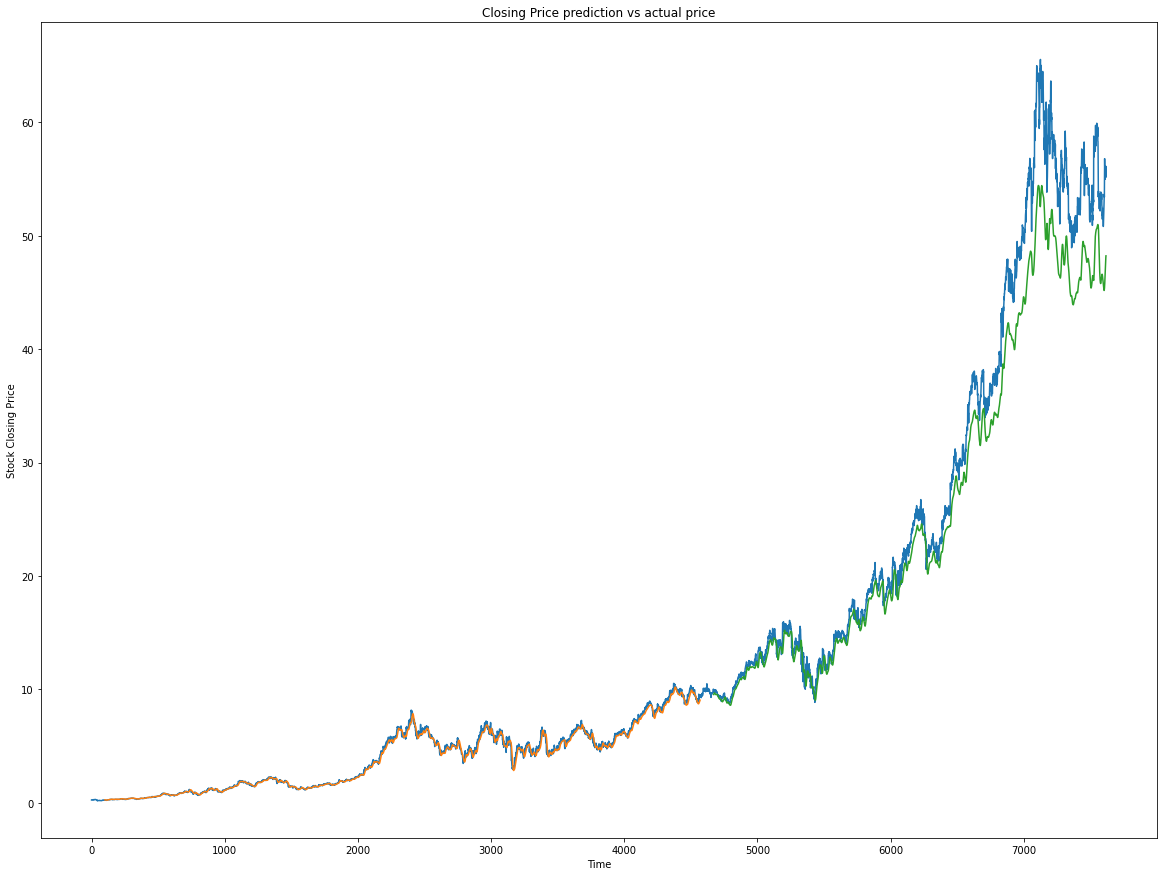

In [12]:
nike_company_model = LstmModel(file_path = "Stocks/nke.us.txt", num_epochs=10, time_step=100)
nike_company_model.run_model()

## Predict the closing price against the date of Pfizer and show the results as a graph.

Starting Date of time series data: 

         Date    Open    High      Low   Close    Volume  OpenInt
0  1982-01-04  0.5243  0.5324  0.51690  0.5169   4176469        0
1  1982-01-05  0.5169  0.5169  0.50890  0.5089   7494341        0
2  1982-01-06  0.5009  0.5169  0.49294  0.5169  16681350        0
3  1982-01-07  0.5243  0.5324  0.51690  0.5243  26205667        0
4  1982-01-08  0.5324  0.5400  0.52430  0.5324  22575014        0


Ending Date of time series data: 

            Date    Open    High     Low  Close    Volume  OpenInt
9037  2017-11-06  35.268  35.288  34.802  35.00  10722965        0
9038  2017-11-07  34.980  35.099  34.921  35.04  10992031        0
9039  2017-11-08  35.050  35.070  34.713  35.02  13693200        0
9040  2017-11-09  35.080  35.250  34.840  35.20  13364668        0
9041  2017-11-10  35.100  35.190  34.795  35.18  15045115        0


Extracting stock price closing value...

0        0.5169
1        0.5089
2        0.5169
3        0.5243
4        0.5324
     

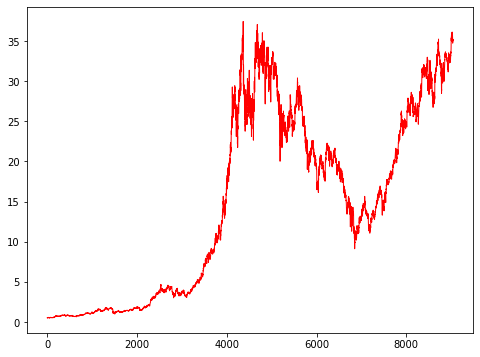

Scaling data to fit within a range of 0 - 1... 

[[4.33098468e-04]
 [2.16549234e-04]
 [4.33098468e-04]
 ...
 [9.34385582e-01]
 [9.39257940e-01]
 [9.38716567e-01]]


Splitting the data.
Training Size: 5425.
Testing Size: 3617

Transforming data to have 100 dependent variables and one target...
Feature Data shape:  (5324, 100)
Target Data shape:  (5324,)


Transforming data to have 100 dependent variables and one target...
Feature Data shape:  (3516, 100)
Target Data shape:  (3516,)


Initializing LSTM model... 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     

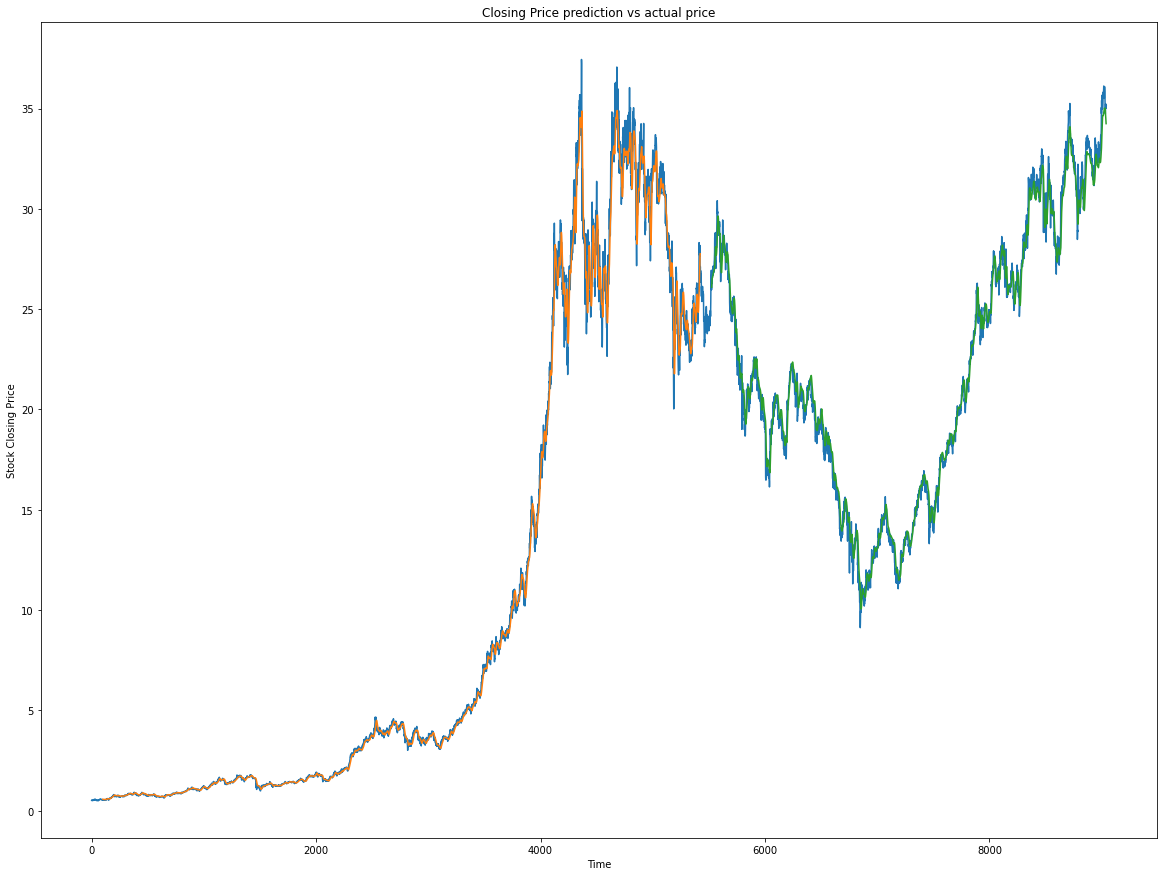

In [11]:
pfe_company_model = LstmModel(file_path = "Stocks/pfe.us.txt", num_epochs=10, time_step=100)
pfe_company_model.run_model()